In [26]:
from ilqr.envs import PointMass, Arm
from matplotlib import animation
from IPython.display import HTML
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import matplotlib
import ipdb
import io

%matplotlib inline
%load_ext autoreload
%autoreload 2

# utility function

# show videos in ipython given frames
# modified from: https://colab.research.google.com/github/deepmind/dm_control/blob/master/tutorial.ipynb#scrollTo=gKc1FNhKiVJX
def display_video(frames, framerate=30):
    dpi=70
    height, width = frames[0].shape[:2]
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width/dpi, height/dpi), dpi=dpi);

    matplotlib.use(orig_backend)  # switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])

    im = ax.imshow(frames[0], aspect='auto');
    def update(frame):
      im.set_data(frame)
      return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [206]:
def iLQR(env, iterations=100, 
         reg = 1,                  # initial regularization
         reg_lims = (1e-6, 1e10),  # limtis on regularization
         dreg = 2,                 # reg is multiplied or divided by dreg
         dreg_factor = 1.6,        # dreg is multiplied or diveded by dreg_factor):
         alpha = 1,
         verbose = False,
        ):        

    """
    todo:
    - line search for alpha parameter
    - convergence check
    - control limits (box QP)
    
    fixes:
    - moidfy matrix inversion
    - simpler V updates
    - divergence check
    - add control cost
    - add alpha
    - add reg to V_xx, not Q_xx
    """

    # initial trajectory
    actions = [(0,0) for i in range(env.max_steps)]
    states, costs, costs_derivs = env.rollout(actions)
    state_derivs = [env.state_derivs(s,a) for s,a in zip(states, actions)]
    V_x  = costs_derivs[-1]['l_x']
    V_xx = costs_derivs[-1]['l_xx']
    history = dict(cost=[sum(costs)], reg=[reg])

    for i in tqdm(range(iterations)) if not verbose else range(iterations):
        k, K = [], []
        diverged = False

        # backward pass
        # (compute new control rules k and K)
        for t in range(env.max_steps-1, -1, -1):
            l, f = costs_derivs[t], state_derivs[t]

            Q_x  = l['l_x']  + f['f_x'].T @ V_x
            Q_u  = l['l_u']  + f['f_u'].T @ V_x
            Q_xx = l['l_xx'] + f['f_x'].T @ V_xx @ f['f_x']
            Q_uu = l['l_uu'] + f['f_u'].T @ V_xx @ f['f_u']
            Q_ux = l['l_ux'] + f['f_u'].T @ V_xx @ f['f_x']

            # compute Q_uu inverse
            Q_uu += np.diag([reg]*len(Q_u))
            
            try:
                # cholesky decomposition for matrix inverse
                L = np.linalg.cholesky(Q_uu)
                k.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_u)))
                K.append(-np.linalg.solve(L.T, np.linalg.solve(L, Q_ux)))
            except np.linalg.LinAlgError:
                # increase regularization
                dreg = max(dreg_factor, dreg_factor*dreg)
                reg = min(max(reg*dreg, reg_lims[0]), reg_lims[1])
                
                history['cost'].append(sum(costs))
                history['reg'].append(reg)
                
                # abort backward pass
                if verbose: print('({:3d}/{}) divereged at time {} with reg {:.1e}...'.format(
                    i, iterations, t, reg))
                diverged = True
                break

            # update V
            V_x  = Q_x  + K[-1].T @ Q_uu @ k[-1] + K[-1].T @ Q_u  + Q_ux.T @ k[-1]
            V_xx = Q_xx + K[-1].T @ Q_uu @ K[-1] + K[-1].T @ Q_ux + Q_ux.T @ K[-1]

            # check for bad things
            for x in [Q_x, Q_u, Q_xx, Q_uu, Q_ux, Q_uu_inv, V_x, V_xx]:
                if np.any(np.isnan(x)) or np.any(np.isinf(x)):
                    ipdb.set_trace()
        
        if not diverged:
            k.reverse()
            K.reverse()

            # forward pass
            # (compute new trajectory with new control law)
            states_new, costs_new, actions_new = [], [], []
            states_new.append(env.reset(reset_target=False))

            for t in range(env.max_steps):
                action_new = actions[t] + alpha*k[t] + K[t] @ (states_new[-1] - states[t])
                actions_new.append(action_new)
                costs_new.append(env.cost(states_new[-1], actions_new[-1])[0])
                states_new.append(env.step(actions_new[-1]))
            history['cost'].append(sum(costs_new))

            # regularization update
            delta_cost = sum(costs_new) - sum(costs)

            # increase regularization
            if delta_cost>0:
                if verbose: print('({:3d}/{}) cost increased by {:.2f} with reg {:.1e}...'.format(
                    i, iterations, delta_cost, reg))
                dreg = max(dreg_factor, dreg_factor*dreg)
                reg = min(max(reg*dreg, reg_lims[0]), reg_lims[1])

            # decrease regularization
            else:
                if verbose: print('({:3d}/{}) cost decreased by {:.2f} with reg {:.1e}...'.format(
                    i, iterations, delta_cost, reg))
                dreg = min(1/dreg_factor, dreg/dreg_factor)
                reg *= dreg * (reg > reg_lims[0])  # latter term sets reg=0 if reg<=reg_lims[0]

                actions = actions_new.copy()
                states = states_new.copy()
                costs = costs_new.copy()
            history['reg'].append(reg)
    
    return actions, history

# two link arm

(  0/100) cost decreased by -0.22 with reg 1.0e+00...
(  1/100) divereged at time 17 with reg 1.0e+00...
(  2/100) divereged at time 98 with reg 2.6e+00...
(  3/100) divereged at time 99 with reg 1.0e+01...
(  4/100) divereged at time 96 with reg 6.9e+01...
(  5/100) divereged at time 99 with reg 7.2e+02...
(  6/100) divereged at time 98 with reg 1.2e+04...
(  7/100) divereged at time 85 with reg 3.2e+05...
(  8/100) divereged at time 90 with reg 1.4e+07...
(  9/100) divereged at time 76 with reg 9.6e+08...
( 10/100) divereged at time 74 with reg 1.1e+11...
( 11/100) divereged at time 99 with reg 1.9e+13...
( 12/100) divereged at time 91 with reg 5.2e+15...
( 13/100) divereged at time 74 with reg 2.3e+18...
( 14/100) divereged at time 99 with reg 1.7e+21...
( 15/100) divereged at time 83 with reg 2.0e+24...
( 16/100) divereged at time 74 with reg 3.6e+27...
( 17/100) divereged at time 97 with reg 1.1e+31...
( 18/100) divereged at time 74 with reg 5.0e+34...
( 19/100) divereged at time 

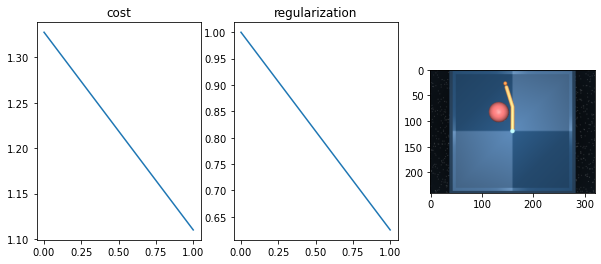

In [224]:
# run ilqr
env = Arm()
actions, history = iLQR(env, iterations=100, reg=1, alpha=1, verbose=True, reg_lims=(1e-6, 1e100))

ax = plt.subplots(1, 3, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');
ax[2].imshow(env.render());

In [221]:
# show video
env.reset(reset_target=False)
imgs = [env.render()]
for action in actions:
    env.step(action)
    imgs.append(env.render())
#     print(action, env.env.physics.finger_to_target_dist(), env.env.physics.time())
display_video(imgs, framerate=(1/env.dt))
 


0.22753540935149136

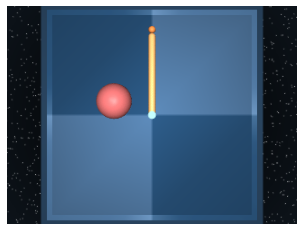

In [185]:
env = Arm()
env.show()
env.env.physics.finger_to_target_dist()

# point mass

100%|██████████| 100/100 [00:04<00:00, 23.95it/s]


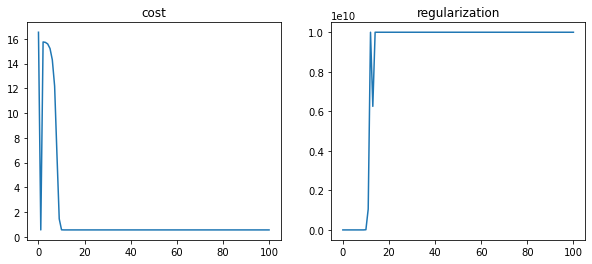

In [45]:
# run ilqr
env = PointMass()
actions, history = iLQR(env, iterations=100, reg=1e-2)
ax = plt.subplots(1,2, figsize=(10,4))[1];
ax[0].plot(history['cost']); ax[0].set_title('cost');
ax[1].plot(history['reg']);  ax[1].set_title('regularization');

In [46]:
# show video
env.reset(reset_target=False)
imgs= []
for action in actions:
    env.step(action)
    imgs.append(env.render())
display_video(imgs, framerate=(1/env.dt))